In [1]:
import tifffile
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
store = tifffile.imread('./Calib_Polaris_Scan3.qptiff', aszarr=True)
zarr_pyramids = zarr.open(store, mode='r')
image = np.array(zarr_pyramids[6])

1. Image preprocessing

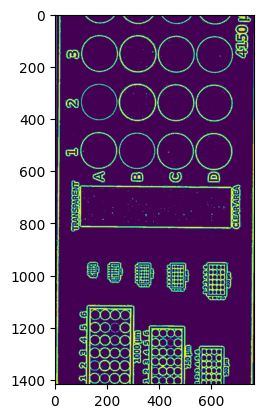

In [3]:
def image_preprocessing(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return(binary_image)

image_processed = image_preprocessing(image)
plt.imshow(image_processed)

2. Rectangle and its points (for all recognized rectangles)

In [4]:
def fing_rectangle_pts(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangle_pts = []
    for contour in contours:
        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            pts = approx.reshape(-1, 2)
            pts = np.array(pts, dtype=np.float32)
            rectangle_pts.append(pts)
            
    return(rectangle_pts)

rectangle_pts = fing_rectangle_pts(image_processed)
rectangle_pts 

[array([[ 561., 1280.],
        [ 559., 1416.],
        [ 637., 1416.],
        [ 639., 1282.]], dtype=float32),
 array([[ 369., 1202.],
        [ 367., 1416.],
        [ 485., 1416.],
        [ 488., 1204.]], dtype=float32),
 array([[ 131., 1125.],
        [ 129., 1416.],
        [ 289., 1416.],
        [ 292., 1127.]], dtype=float32),
 array([[ 63., 643.],
        [ 65., 832.],
        [708., 813.],
        [702., 653.]], dtype=float32)]

3. Aligned picture (if rectangle is rotated)


we will need **src_pts** (source points), **w** and **h** - widht and height of this rectangle (based on source points) and **dst_pts** (destination points)

160.5 290.0


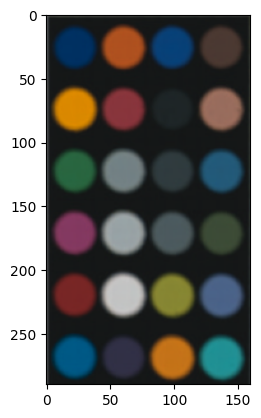

In [5]:
i = 2 # for first rectangle
src_pts = rectangle_pts[i]

def find_dst_pts(src_pts):
    w = abs((src_pts[0][0]+src_pts[1][0])/2 - (src_pts[2][0]+src_pts[3][0])/2)
    h = abs((src_pts[0][1]+src_pts[3][1])/2 - (src_pts[1][1]+src_pts[2][1])/2)
    return w,h

w, h = find_dst_pts(src_pts)
print(w, h)
dst_pts = np.array([[0, 0], [0, h],  [w, h], [w, 0]], dtype=np.float32)

# lets transform rectangle using src_pts, w, h, dst_pts
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)

4. And we can also achieve aligned picture in high resolution

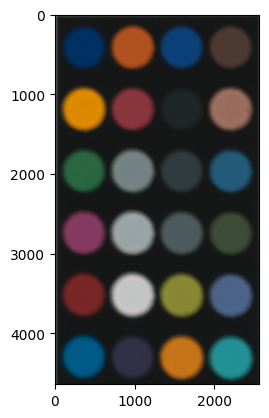

In [6]:
layer = 2 # lets go from 6 layer to 2
image_high_res = np.array(zarr_pyramids[6-(6-layer)])


# lets find src_pts, w, h, dst_pts

coef = 2**(6-layer)
src_pts = src_pts * coef #src_pts

w, h = w * coef, h * coef # w, h
dst_pts = dst_pts * coef # dst_pts

# and transform

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp = cv2.warpPerspective(image_high_res, M, (int(w), int(h)))

if warp.shape[0] < warp.shape[1]: # for CA
    warp = warp[int(h*0.3):-int(h*0.3),int(w*0.3):-int(w*0.3),:]

plt.imshow(warp)